In [1]:
from functools import partial

import numpy as np
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson 
from scipy.special import logsumexp
import statsmodels.api as sm

import pickle
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from jax import vmap

from dynamax.hidden_markov_model import PoissonHMM
import matplotx
plt.style.use(matplotx.styles.aura["dark"])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [3]:
# constructing design matrix with all trials and all neurons
# np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 10
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
trial_id = []
X = []


for trial_idx in trial_indices:
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    trial_length = trial_end - trial_start

    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    lcue_times = data["cueOnset_L"][trial_idx]
    rcue_times = data["cueOnset_R"][trial_idx]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

   

    X.append(np.hstack((X_sr, X_sl, np.ones((X_sr.shape[0], 1)))))
    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))


trial_id = np.concatenate(trial_id).astype(int)
X = np.vstack(X)
print(f'X shape = {X.shape}')


number of trials: 290
X shape = (13238, 61)


transition matrix: 
[[0.94 0.01 0.05]
 [0.22 0.75 0.03]
 [0.   0.04 0.96]]


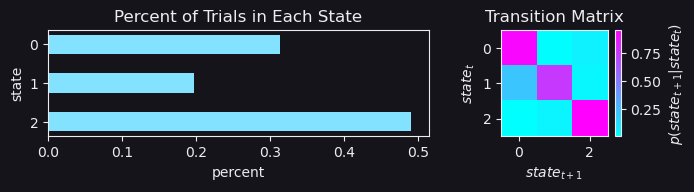

In [4]:
# Generating states for simulation
np.random.seed(1)
n_states = 3
t_init = np.array([1.4, 0.7, 0.7])[:n_states]
T_sim = np.array([dirichlet(np.roll(t_init**(n+1), n)).rvs()[0] for n in range(n_states)])
dist_init = np.array([0.8, 0.1, 0.1])[:n_states]
dist_init /= dist_init.sum()
sim_states = np.ones(trial_indices.size).astype(int)
for i in range(sim_states.size):
    if i == 0:
        sim_states[i] = np.random.choice(np.arange(n_states), 1, p=dist_init)
    sim_states[i] = np.random.choice(np.arange(n_states), 1, p=T_sim[sim_states[i-1]])

print(f'transition matrix: \n{np.round(T_sim, 2)}')
fig, axs = plt.subplots(1, 2, figsize=(7, 2), gridspec_kw={'width_ratios': [5, 2]})
_ = axs[0].hist(sim_states, bins=np.arange(-0.5, 2.51, 1), density=True, rwidth=0.5, orientation='horizontal')
axs[0].set_title('Percent of Trials in Each State')
axs[0].set_xlabel('percent')
axs[0].set_ylabel('state')
axs[0].set_ylim(axs[0].get_ylim()[::-1])
im = axs[1].imshow(T_sim, cmap='cool', origin='upper')
plt.colorbar(im, ax=axs[1], label='$p(state_{t+1} | state_t)$')
axs[1].set_title('Transition Matrix')
axs[1].set_ylabel(r'$state_t$')
axs[1].set_xlabel(r'$state_{t+1}$')
plt.tight_layout()

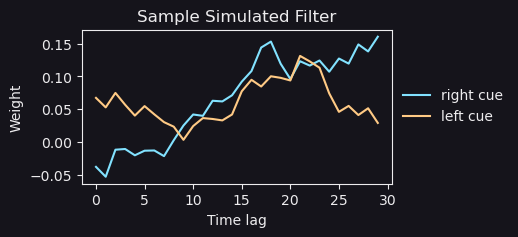

In [5]:
# generating parameters for each state for each neuron
# np.random.seed(0)
n_filters = 2
theta_sim = np.empty((n_states, filt_len*n_filters+1, n_neurons))
for n in range(n_neurons):
    for s in range(n_states):
        for f in range(n_filters):  # 2 filters, right stim, left stim, (no spikes for simulated data)
            for i in range(filt_len):
                if i == 0:
                    theta_sim[s, i+(f * filt_len), n] = np.random.normal(0, 0.1)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
                else:
                    theta_sim[s, i+(f*filt_len), n] = np.random.normal(theta_sim[s, i+(f*filt_len)-1, n], .02)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
        theta_sim[s, -1, n] = np.random.normal(0.15, 0.05) #bias term

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(theta_sim[0, :-1, 1].reshape(2, -1).T, label=['right cue', 'left cue'])
ax.set_title('Sample Simulated Filter')
ax.set_xlabel('Time lag')
ax.set_ylabel('Weight')
plt.legend(bbox_to_anchor=(1.4, 0.7))


(13238, 10)


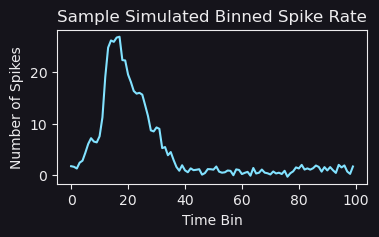

In [6]:
# generating spike rate data
y_sim = []
for trial in np.unique(trial_id):
    x_idx = np.argwhere(trial_id==trial)
    y_sim.append(np.squeeze(X[x_idx] @ theta_sim[sim_states[trial]]))

y_sim = np.exp(np.vstack(y_sim)) + np.random.normal(0, 0.5, size = (X.shape[0], n_neurons))
# y_sim = np.round(y_sim, 2)
print(y_sim.shape)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(y_sim[:100, 0])
ax.set_title('Sample Simulated Binned Spike Rate')
ax.set_xlabel('Time Bin')
ax.set_ylabel('Number of Spikes');


In [7]:
#initial glm with no states to estimate weights
theta_init = np.empty(theta_sim[0].shape)
sta = (X.T @ y_sim) / y_sim.sum()
glms = [None for _ in range(n_neurons)]

for neuron in range(n_neurons):
    glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson())
    glms[neuron] = glm
    a = 0.001 * np.ones(X.shape[1])
    a[-1] = 0
    res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

    w = res.params
    theta_init[:, neuron] = w


In [30]:
n_states = 3


In [16]:
def get_poiss_ll(X, y, theta):
    v = X @ theta
    r = np.exp(v)
    ll = y * np.log(r) - r
    ll = ll.sum(axis=(1, 2))
    # print(ll.shape)
    return ll - logsumexp(ll)
n_trials = np.unique(trial_id).size
print(n_trials)
theta_hmm = np.ones((n_states, X.shape[1], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, .1, size=theta_hmm.shape)

loglikeli = np.empty((n_states, np.unique(trial_id).size))
for t in np.unique(trial_id):
    x_idx = np.argwhere(trial_id==t).squeeze()
    loglikeli[:, t] = get_poiss_ll(X[x_idx], y_sim[x_idx], theta_hmm)

model = PoissonHMM(num_states=3, emission_dim=n_trials, transition_matrix_stickiness=1, emission_prior_concentration=1/n_states)

params, props = model.initialize(emission_rates=jnp.array(np.exp(loglikeli)))
posterior = model.smoother(params, emissions=params.emissions.rates)

290


In [17]:
posterior

HMMPosterior(marginal_loglik=Array(-309.61053, dtype=float32), filtered_probs=Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), predicted_probs=Array([[0.49839333, 0.4080342 , 0.09357239],
       [0.5167748 , 0.17251119, 0.31071413],
       [0.4185056 , 0.36981463, 0.21167971]], dtype=float32), smoothed_probs=Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), initial_probs=Array([1., 0., 0.], dtype=float32), trans_probs=Array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32))

In [33]:
params

ParamsPoissonHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.49839333, 0.4080342 , 0.09357239], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.5167748 , 0.17251119, 0.31071413],
       [0.4185056 , 0.36981463, 0.21167971],
       [0.15381943, 0.29386514, 0.5523155 ]], dtype=float32)), emissions=ParamsPoissonHMMEmissions(rates=Array([[9.8584709e+00, 1.3777172e+01, 1.4630659e+00, 4.4542545e-01,
        6.5763225e-04, 4.6183925e-07, 4.4238484e-01, 1.0222112e+00,
        4.4323683e-02, 3.4278691e-01],
       [9.1970453e+00, 2.2740108e+01, 2.6376551e-01, 3.0492996e-03,
        3.2942800e-05, 7.4389207e-01, 9.9264884e-01, 1.0945299e+00,
        1.7976875e+01, 1.3224293e-02],
       [1.6177617e+00, 1.8005801e+00, 1.0375442e-03, 1.4785974e+00,
        2.1258866e-02, 6.2638612e+00, 1.0278230e+01, 2.6313512e+00,
        5.4338592e-01, 1.2305752e+01]], dtype=float32)))